# 네이버 영화 리뷰 감성 분석

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f2e26fa1950>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
train_data[:20]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [5]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.2 MB/s 
     |████████████████████████████████| 453 kB 51.1 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-09-13 07:11:17--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.

## 2. 데이터로더 구성

In [6]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [7]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [8]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    return result

In [9]:
def load_data(train_data, test_data, num_words=10000):

    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중...
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [10]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [11]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index): ##### 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. ##### 숫자 -> 텍스트
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [15]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.96938143432699
문장길이 최대 : 116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [17]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델 구성 및 validation 구성

In [18]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [19]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [20]:
print(partial_x_train)

[[   0    0    0 ...    6    4    4]
 [   0    0    0 ... 3017  507    5]
 [   0    0    0 ...   94 2584    4]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...   60  395 8572]
 [   0    0    0 ...   88 2740    5]]


In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 16s 22ms/step - loss: 0.4701 - accuracy: 0.8019 - val_loss: 0.3627 - val_accuracy: 0.8471
Epoch 2/100
188/188 [==============================] - 3s 15ms/step - loss: 0.3320 - accuracy: 0.8622 - val_loss: 0.3523 - val_accuracy: 0.8483
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2968 - accuracy: 0.8788 - val_loss: 0.3434 - val_accuracy: 0.8524
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2708 - accuracy: 0.8904 - val_loss: 0.3532 - val_accuracy: 0.8518
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2454 - accuracy: 0.9018 - val_loss: 0.3618 - val_accuracy: 0.8525
Epoch 6/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2232 - accuracy: 0.9112 - val_loss: 0.3765 - val_accuracy: 0.8517
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2016 - accuracy: 0.9205 - val_loss: 0.3888 - val_accuracy: 0.8

In [22]:
results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 4s - loss: 1.6695 - accuracy: 0.8158 - 4s/epoch - 3ms/step


In [23]:
print(results)

[1.669488787651062, 0.8158349990844727]


## 6. loss, accuracy 그래프 시각화

In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

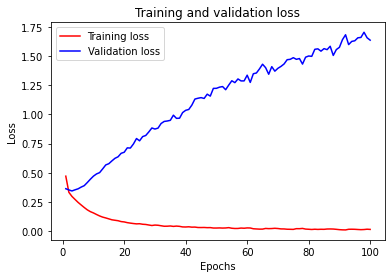

In [26]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

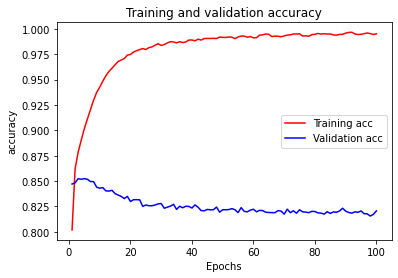

In [27]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 학습된 embedding layer 분석

In [29]:
# gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './word2vec.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 

vectors = model.get_weights()[0]

for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증']
vector

array([ 2.57160366e-01, -1.28536433e-01, -8.17699824e-03, -8.05461928e-02,
       -2.26843134e-01, -2.46369481e-01, -3.47744405e-01,  5.39722145e-02,
        2.51403332e-01, -3.72760803e-01,  1.75575897e-01,  2.54752398e-01,
       -1.84847981e-01,  1.45217195e-01, -2.73958147e-01,  2.33933255e-01,
        2.14778781e-01, -5.15745506e-02,  1.68176368e-01, -1.92029580e-01,
       -3.99889983e-02,  1.16072647e-01,  2.15486035e-01, -2.31127813e-01,
        2.18142316e-01, -1.34621873e-01,  1.23741597e-01, -5.06623052e-02,
        1.00032642e-01, -1.10974133e-01,  1.37910753e-01,  1.26700431e-01,
       -1.97726905e-01,  7.00983437e-05, -2.23606750e-01, -3.97409759e-02,
       -1.38009982e-02, -2.89624870e-01,  7.09116235e-02,  1.58217579e-01,
       -2.12964728e-01, -1.08795185e-02,  2.78942157e-02,  1.35750890e-01,
       -1.75605506e-01, -4.27221283e-02,  1.56861678e-01,  3.44025314e-01,
        1.76077768e-01, -1.14616752e-01,  1.35420337e-01,  3.40613991e-01,
       -2.60815203e-01, -

In [32]:
word_vectors.similar_by_word("재미")

[('귀여운', 0.6285099983215332),
 ('젤', 0.6214285492897034),
 ('이렇게', 0.6176687479019165),
 ('진짜', 0.6007812023162842),
 ('이완', 0.5990417003631592),
 ('창조', 0.5872508883476257),
 ('명치', 0.5840135216712952),
 ('다간', 0.5658212900161743),
 ('뭔지', 0.5531925559043884),
 ('L', 0.5496768355369568)]

# 한국어 word2vec 임베딩을 활용해 성능 개선

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import gensim

word2vec_path = '/content/drive/MyDrive/dataset/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['감동']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-1.4411083 , -0.78142536,  2.453768  , -0.86445606,  0.24195324,
        0.36006922, -1.0639709 ,  0.85037315, -1.0184479 ,  0.21196692,
       -0.6679936 ,  0.6389819 , -0.26964295,  0.66028535,  0.39613017,
        0.6428288 ,  0.6648245 ,  0.08363932, -0.2540794 ,  0.55310047,
        0.63392764,  0.19311981, -0.4648248 ,  0.1490374 ,  2.0762694 ,
        0.7872764 , -0.21711552, -0.59049505, -1.3264338 , -0.06233318,
        1.2550159 , -0.05334642, -0.5453753 , -0.8736315 ,  0.5253877 ,
        0.03122815,  0.8280226 ,  0.23597455,  0.06136359,  1.5114233 ,
       -0.340495  ,  0.912277  ,  0.5899006 , -1.3025732 , -0.87596595,
        0.21738248,  1.0366931 , -0.55709684, -0.9039502 ,  0.28133616,
       -1.7572548 , -0.29769212, -0.14536098,  0.5850025 , -0.6111547 ,
       -0.29829553,  1.4106004 , -0.38685524,  0.4801454 ,  0.40166005,
        0.28174093,  1.6133646 , -0.8590998 ,  0.49886975,  0.38605362,
       -0.1607663 , -0.87983316,  0.21996935,  0.68561727, -0.84

In [38]:
word2vec.similar_by_word("재미")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [39]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 200 #워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
  if index_to_word[i] in word2vec:
    embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer = Constant(embedding_matrix), # 카피한 word2vec임베딩 적용
                                 input_length = maxlen,
                                 trainable=True # Fine-tuning
))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 39, 16)            9616      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 16)            784       
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [48]:
# 학습 방법 정의
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 10s 10ms/step - loss: 0.6153 - accuracy: 0.6522 - val_loss: 0.5189 - val_accuracy: 0.7432
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4627 - accuracy: 0.7805 - val_loss: 0.4345 - val_accuracy: 0.7978
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3868 - accuracy: 0.8262 - val_loss: 0.3997 - val_accuracy: 0.8184
Epoch 4/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3412 - accuracy: 0.8511 - val_loss: 0.3836 - val_accuracy: 0.8286
Epoch 5/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3097 - accuracy: 0.8681 - val_loss: 0.3821 - val_accuracy: 0.8333
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2840 - accuracy: 0.8807 - val_loss: 0.3831 - val_accuracy: 0.8329
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2607 - accuracy: 0.8943 - val_loss: 0.3915 - val_accuracy: 0.8340
Epoc

In [49]:
results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 5s - loss: 0.8106 - accuracy: 0.8062 - 5s/epoch - 4ms/step


In [50]:
results

[0.8106459379196167, 0.8061923980712891]